apm 192.38.81.6_gk_model0 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            2
   Constants    :            0
   Variables    :            7
   Intermediates:            0
   Connections  :            4
   Equations    :            2
   Residuals    :            2
 
 Number of state variables:           9568
 Number of total equations: -         9269
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :            299
 
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipopt,

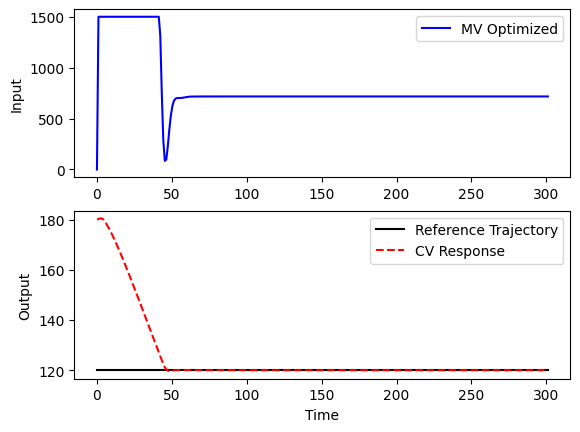

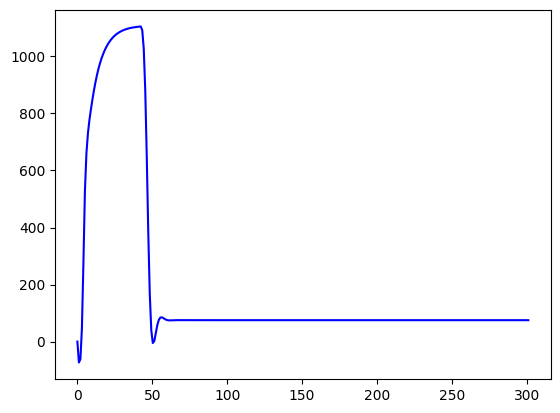

In [1]:
from gekko import GEKKO
import numpy as np
from random import random
import matplotlib.pyplot as plt
%matplotlib inline

m = GEKKO()
m.time = np.linspace(0,301,300)

# Parameters
mass = 500
b = m.Param(value=50)
K = m.Param(value=0.8)

# Manipulated variable
w = m.MV(value=0, lb = 0, ub = 1500)
w.STATUS = 1  # allow optimizer to change
#w.DCOST = 0.1 # smooth out gas pedal movement
#w.DMAX = 20   # slow down change of gas pedal

# Controlled Variable
Qout = m.CV(value=0)
P = m.CV(value=0)
h = m.CV(value=180)
h.STATUS = 1  # add the SP to the objective
m.options.CV_TYPE = 2 # squared error
h.SP = 120     # set point
h.TR_INIT = 1 # set point trajectory
h.TAU = 5     # time constant of trajectory

# Process model
#m.Equation(mass*h.dt() == -v*b + K*b*p)

A_power = np.array([[3.7971E-01],\
                    [5.1151E-02],\
                    [3.1656E-01]])
A_outflow = np.array([[1.2995],\
                    [-4.3918E-01],\
                    [4.5231E-02],\
                    [0],\
                    [1.0387E-02]])

# B (ny x (nb x nu))
B_power = np.array([[[5.5404E-02],[-1.4118E-02],[-2.3452E-02]]]).T
B_outflow = np.array([[[7.1049E-02],[4.1327E-02],[6.4801E-02],[0],[-6.6199E-02]]]).T

C_power = np.array([-6.6831])
C_outflow = np.array([-7.3292E+01])

p_power = {'a':A_power,'b':B_power,'c':C_power}
p_outflow = {'a':A_outflow,'b':B_outflow,'c':C_outflow}

m.arx(p_power,P,w)
m.arx(p_outflow,Qout,w)

#                               Qout = Qout if (RPM > 750) else 0
m.Equation(h.dt() == 1/18 *(75 - m.if3(w-750,0,Qout))/3600*100)


#m.Equation(h.dt() == 1/18 *(75 - m.abs3(Qout))/3600*100)
m.Equation(h.dt() == 1/18 *(75 - Qout)/3600*100)
dh = m.Var()
m.Equation(h.dt() == dh*100)

m.options.IMODE = 6 # control
m.solve(disp=True)

print(Qout.VALUE)


# get additional solution information
import json
with open(m.path+'//results.json') as f:
    results = json.load(f)

plt.figure()
plt.subplot(2,1,1)
plt.plot(m.time,w.value,'b-',label='MV Optimized')
plt.legend()
plt.ylabel('Input')
plt.subplot(2,1,2)
plt.plot(m.time,results['v3.sp'],'k-',label='Reference Trajectory')
plt.plot(m.time,h.value,'r--',label='CV Response')
plt.ylabel('Output')
plt.xlabel('Time')
plt.legend(loc='best')

plt.figure()
plt.plot(m.time,Qout.value,'b-',label='MV Optimized')
plt.show()
